# Auto-atención enmascarada

La auto-atención tiene la característica que, al asumir una gráfica completamente conectada, toma en cuenta para la representación de un elemento, todos los elementos que aparecen en su contexto, incluyendo aquellos elementos que aparecen posteriormente a este elemento. En la matriz de pesos de atención podemos ver que todas las entradas tienen un peso de atención asignado, lo que implica que existe una relación entre los elementos, incluso los elementos futuros. Esto es, si tenemos un tóken $w_i$, en la capa de auto-atención se asumirá que tiene una relación con cada elemento $w_{i+t}$, con $t \in \{1,...,n-i\}$. Sin embargo, esto puede ser problemático en varios casos, pues cómo hemos visto en los ejemplos <a href="https://victormijangosdelacruz.github.io/MecanismosAtencion/html/06AttentionHead.html">anteriores</a>, al predecir la palabra siguiente, la cabeza de atención pondrá atención en esta palabra, en tanto tiene la capacidad de observarla. 

Para evitar este sesgo, se utiliza un <b>enmascaramiento</b> de las palabras subsecuentes. El enmascaramiento es un procedimiento importante que ayuda a definiri modelos del lenguaje y otros procedimientos cuando no se cuenta (o no se quiere que la máquina cuente) con información a futuro:

<b>Enmascaramiento:</b> El enmascaramiento reemplaza un tóken $w_i$ por una etiqueta <tt>MASK</tt> para que el modelo no tenga información de esta etiqueta. Este proceso oculta un tóken para que no sea accesible a la auto-atención.

El enmascaramiento tiene varias aplicaciones. Por ejemplo, en modelos de lenguaje como BERT (Devlin et al., 2019) utilizan el enmascaramiento para ocultar ciertas palabras que despúes pueden ser predichas por el modelo. En este ejemplo, nos enfocaremos a enmascarar las palabras que se encuentran posteriormenta a unl tóken actual. De tal forma que en la matriz de pesos de atención sólo consideraremos los pesos de la parte triangular inferior de la matriz:

<img src="images/AbsmaskedAtt.png" width="430" class="center">

El primer tóken no se relacona más que consigo mismo, el segundo sólo consigo mismo y con el tóken previo, y asi consecutivamente, de tal forma que cada tóken se relaciona únicamente con los tókens previos. En este caso, los pesos que representan las relaciones con los tókens siguientes se interpretan como $-\infty$, esto debido a que el softmax de menos infinito es 0; de esta forma, podemos observar que $\alpha(x_i, x_{j}) = 0$ si $j > i$. De esta forma, la representación de un elemento sólo dependerá de los elementos previos, pues el peso de atención 0 ignorará los elementos siguientes.

Para implementar este tipo de enmascaramiento utilizamos una matriz con valores booleanos, de tal forma que sólo se conserven aquellos valores de la parte diagonal inferior. Los elementos de la parte diagonal superior los llenamos con valores grandes (lo suficientemente grandes para que su softmax sea 0). 

De esta forma, definimos una clase que contenga la auto-atención enmascarada a partir de generar una matriz que sólo contenga valores en la parte triangular inferior. Por lo demás, el mecanismo de atención es similar a la auto-atención definida en la sección de <a href="https://victormijangosdelacruz.github.io/MecanismosAtencion/html/02SelfAttention.html">auto-atención común</a>.

In [1]:
import torch
import torch.nn as nn
import numpy as np

class MaskAttention(nn.Module):
    #Atención enmascarando subsecuentes
    def __init__(self, d_model):
        super(MaskAttention, self).__init__()
        self.d_model = d_model
        self.Q = nn.Linear(d_model, d_model, bias=False)
        self.K = nn.Linear(d_model, d_model, bias=False)
        self.V = nn.Linear(d_model, d_model, bias=False)

    def forward(self, x):
        query, key, value = self.Q(x), self.K(x), self.V(x)
        scores = torch.matmul(query, key.T)/np.sqrt(self.d_model)
        #Enmascaramiento de los scores
        mask  = self.masking(x)
        scores = scores.masked_fill(mask == 0, -1e9)
        att = nn.functional.softmax(scores, dim=-1)
        h = torch.matmul(att, value)

        return h, att

    def masking(self, x):
        #Creación de la máscara
        n = x.size(0)
        subsequent_mask = np.triu(np.ones((n, n)), k=1).astype('uint8')
        
        return torch.from_numpy(subsequent_mask) == 0

## Aplicación de la auto-atención enmascarada

Podemos definir un módulo con auto-atención enmascarada para generar la predicción del tóken siguiente en una cadena; es decir, un <b>modelo del lenguaje auto-regresivo</b>. El modelo del lenguaje con enmascaramiento es la forma común de realizar los modelos del lenguaje, pues adiferencia de la implementación anterior, en este caso, el modelo no tiene información de las palabras subsiguientes, lo que cumple de manera realista con la tarea de la predicción de los tókens subsiguientes. El único cambio que realizamos con la <a href="https://victormijangosdelacruz.github.io/MecanismosAtencion/html/06AttentionHead.html">implementación sin enmascaramiento</a> es la incorporación de la auto-atención enmascarada.

In [2]:
import copy

class MultiHeadMaskAttention(nn.Module):
    def __init__(self, in_size, d_model, hidden=128, heads=3, dropout=0.3):
        super(MultiHeadMaskAttention, self).__init__()
        self.d_model = d_model
        #Embedding y codificación posicional
        self.enc = Encoding(in_size, d_model)
        #Auto-atención enmascarada
        self.att = nn.ModuleList([copy.deepcopy(MaskAttention(d_model)) for _ in range(heads)])
        #Capa linear para multi cabezas
        self.lin = nn.Linear(heads*d_model, d_model, bias=True)
        #Normalización
        self.norm = LayerNorm(d_model)
        #Red feedforward
        self.ffw = nn.Sequential(nn.Linear(d_model, hidden), nn.ReLU(),
                                nn.Linear(hidden, d_model))
        self.drop1 = nn.Dropout(p=dropout)
        self.drop2 = nn.Dropout(p=dropout)
        self.drop3 = nn.Dropout(p=dropout)
    
    def forward(self, x):
        x_e = self.enc(x)
        x_e = self.drop1(x_e)
        head_att = [head(x_e) for head in self.att]
        self.att_weights = [head[1] for head in head_att]
        heads = [head[0] for head in head_att]
        multi_heads = torch.cat(heads, dim=-1)
        h = self.lin(multi_heads)
        h_norm = x_e + self.norm(h)
        h_norm = self.drop2(h_norm)
        out = self.ffw(h)
        
        return self.drop3(h_norm + self.norm(out))

Al igual que en el caso anterior, definimos funciones para crear el dataset de predicción, tomando como entrada la cadena original con el símbolo de inicio, y como salida la cadena con el símbolo de final:

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
from seaborn import heatmap as hm
from tqdm import tqdm
from transformers import *

#Corpus a utilizar
corpus = ['el perro come un hueso', 'un muchacho jugaba', 'el muchacho saltaba la cuerda',
          'un perro come croquetas', 'el perro come', 'el gato come croquetas', 
          'un gato come', 'un muchacho jugaba con la cuerda', 'el muchacho jugaba con la cuerda']
corpus = [w.split() for w in corpus]
#Creación del vocabulario
voc = vocab()
voc['[bos]'] = 0
voc['[eos]'] = 1
#Indexación de cadenas
sents = list(index(corpus, voc))

#Pares de entrenamiento
x = [torch.cat((torch.tensor([voc['[bos]']]),s), axis=0) for s in sents]
y = [torch.cat((s, torch.tensor([voc['[eos]']])), axis=0) for s in sents]
print(x[0], y[0])

tensor([0, 2, 3, 4, 5, 6]) tensor([2, 3, 4, 5, 6, 1])


Y creamos el modelo como lo hemos realizado anteriormente, definimos una capa lineal con activación softmax para obtener las probabilidade de las salidas.

In [6]:
len_voc = len(voc)
model = nn.Sequential(MultiHeadMaskAttention(len_voc, 128, heads=3), 
                      nn.Linear(128,len_voc), nn.Softmax(1)) 

#Carga del modelo
model.load_state_dict(torch.load('mask_att.model'))
model.eval()

Sequential(
  (0): MultiHeadMaskAttention(
    (enc): Encoding(
      (emb): Embedding(15, 128)
      (pe): PositionalEncoding()
    )
    (att): ModuleList(
      (0-2): 3 x MaskAttention(
        (Q): Linear(in_features=128, out_features=128, bias=False)
        (K): Linear(in_features=128, out_features=128, bias=False)
        (V): Linear(in_features=128, out_features=128, bias=False)
      )
    )
    (lin): Linear(in_features=384, out_features=128, bias=True)
    (norm): LayerNorm()
    (ffw): Sequential(
      (0): Linear(in_features=128, out_features=128, bias=True)
      (1): ReLU()
      (2): Linear(in_features=128, out_features=128, bias=True)
    )
    (drop1): Dropout(p=0.3, inplace=False)
    (drop2): Dropout(p=0.3, inplace=False)
    (drop3): Dropout(p=0.3, inplace=False)
  )
  (1): Linear(in_features=128, out_features=15, bias=True)
  (2): Softmax(dim=1)
)

Si el modelo ya ha sido entrenado, podemos cargarlo, de otra forma, entrenamos el modelo. De nuevo, utilizamos un entrenamiento simple basado en optimizador Adam para simplificar la explicación.

In [6]:
#Función objetivo
loss = nn.CrossEntropyLoss()
#Optimizador
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.01 )
#Núm de épocas
epochs = range(100)

#Entrenamiento
for t in tqdm(epochs):
    for x_i, y_i in zip(x,y):
        prediction = model(x_i)
        optimizer.zero_grad()
        loss_value = loss(prediction, y_i)
        loss_value.backward()
        optimizer.step()
                
#torch.save(model.state_dict(), 'model.model')

100%|█████████████████████████████████████████| 100/100 [00:11<00:00,  8.97it/s]


Podemos ver que los resultados obtenidos son similares a los casos anteriores, aunque pueden mostrar particularidades. En este caso, dado que se trata de un corpus de juguete, no podemos hacer una exploración a fondo de lo que se está aprendiendo, pero podemos darnos una idea de cómo trabajan este tipo de mecanismos:

Palabra siguiente con mayor prob: el


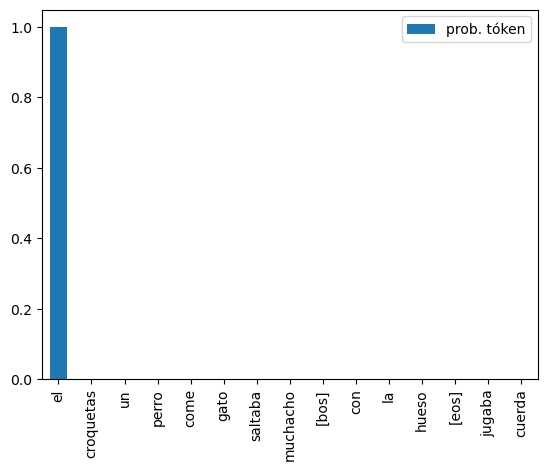

In [7]:
devoc = {i:t for t,i in voc.items()}
def result(text, model):
    #Función para predecir la siguiente palabra dado el contexto
    tokens = text.split()
    x = torch.tensor([voc[t] for t in tokens])
    pred = model(x)
    max_token = pred.argmax(axis=1).detach().numpy()
    
    return pred.detach().numpy(), ' '.join([devoc[i] for i in max_token])

p, pred_text = result('[bos]', model)
print('Palabra siguiente con mayor prob: {}'.format(pred_text))

#Visualización de probabilidades más altas
args = np.argsort(p[-1])[::-1]
probs = np.sort(p[-1])[::-1]
pd.DataFrame(data=probs, columns=['prob. tóken'], index=[devoc[j] for j in args]).plot.bar()
plt.show()

La parte esencial del modelo es la atención. En este caso, hemos usando $N$ cabezales. Podemos notar en los cabezales de atención que obtenemos tienen la característica de que sólo hay un peso de atención con los elementos previos al tóken actual. Esto implica que las relaciones que se establecen dependen del tóken actual pues no existe relación (en una gráfica no hay conexión) entre tókens, cuando el tóken viene después del tóken objetivo.

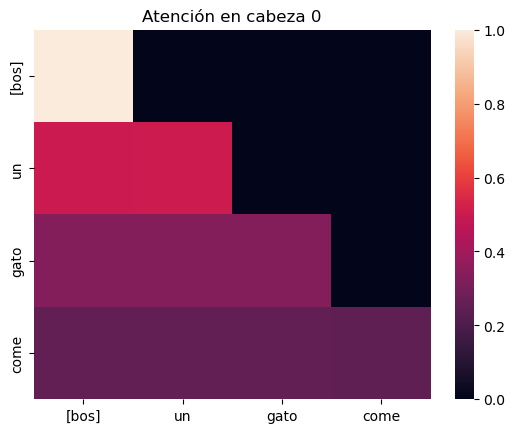

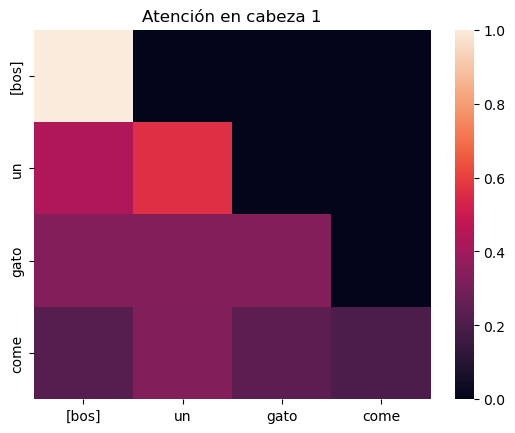

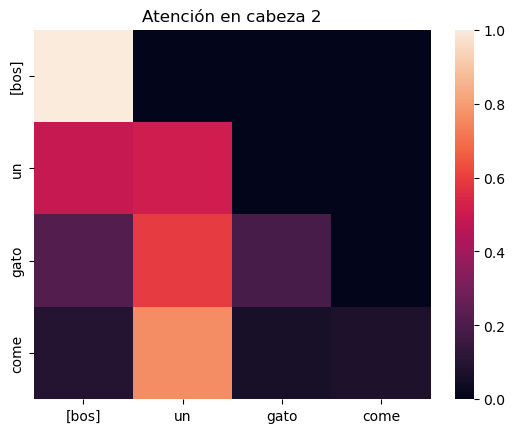

In [8]:
text = '[bos] un gato come'
result(text, model)

for i, att_w in enumerate(model[0].att_weights):
    hm(att_w.detach().numpy(), xticklabels=text.split(), yticklabels=text.split(), vmin=0, vmax=1)
    plt.title('Atención en cabeza %i' %i)
    plt.show()

## Referencias

Devlin, J., Chang, M. W., Lee, K., & Toutanova, K. (2018). Bert: Pre-training of deep bidirectional transformers for language understanding. arXiv preprint arXiv:1810.04805.

Vaswani, A., Shazeer, N., Parmar, N., Uszkoreit, J., Jones, L., Gomez, A. N., ... & Polosukhin, I. (2017). <it>Attention is all you need. Advances in neural information processing systems</it>, 30.

-----------------------------------------------------------------------

<a href="https://victormijangosdelacruz.github.io/MecanismosAtencion/">Principal</a>